### Data Analysis
#### Table of Content
1. [Data Overview](#1-data-overview)
1. [Impact of mapping on Latency](#2-impact-of-mapping-on-latency)

In [79]:
"""
Importing Generated Data  
"""

import os 
import pickle 

directory_path = 'data/task_5'
entries = os.listdir(directory_path)
files = sorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

list_of_dict = []
for file_name in files: 
    file_path = os.path.join(directory_path,file_name)
    with open(file_path, 'rb') as file: 
        dict = pickle.load(file)
        list_of_dict.append(dict)
        
print(f"Number of files in \"{directory_path}\": \t{len(files)}")
print(f"Number of files in imported list: \t{len(list_of_dict)}")

Number of files in "data/task_5": 	3600
Number of files in imported list: 	3600


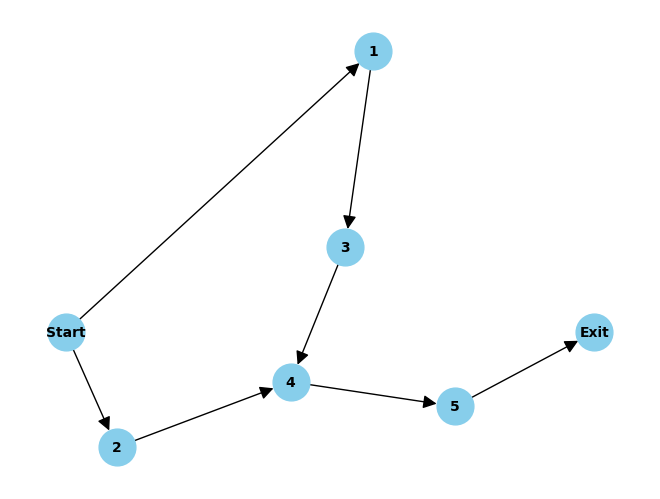

In [80]:
"""
Function for Visualizing Graph Object
"""

import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np

def visGraph(graph, pos=None):
    if pos is None:
        pos = nx.spring_layout(task_graph, seed=42)
        pos['Start'] = np.array([-1,0])
        pos['Exit'] = np.array([1,0])
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', arrowsize=20)
    plt.show()

task_graph = list_of_dict[0]['task_graph']
visGraph(task_graph)

In [81]:
"""
Converting Imported data to Pandas.DataFrame
"""
import pandas as pd 
data_df = pd.DataFrame(list_of_dict)


#### 1. Data overview 

In [82]:

pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("\n\t\t\tFlit Latency (avg) Summary")
print(data_df['avg_flit_lat'].describe())

print("\n\t\t\tPacket Latency (avg) Summary")
print(data_df['avg_packet_lat'].describe())

pd.set_option('display.float_format', None)


			Flit Latency (avg) Summary
count   3600.000
mean      14.809
std        8.572
min        6.129
25%       10.121
50%       11.963
75%       15.486
max       66.361
Name: avg_flit_lat, dtype: float64

			Packet Latency (avg) Summary
count   3600.000
mean      55.903
std       27.367
min       38.000
25%       42.020
50%       43.953
75%       60.270
max      189.872
Name: avg_packet_lat, dtype: float64


In [83]:
"""
Get Latency Distribution from the number of mapping each task has.
    Given Parameters of the DAG and the demand level, this code will fetch all the mapping and then returns the stats for analysis.
"""

def calculateStats(dataframe, column_names):
    stats_dict = {}
    for column_name in column_names:
        column_range = dataframe[column_name].max() - dataframe[column_name].min()
        column_std_dev = dataframe[column_name].std()
        column_mean = dataframe[column_name].mean()
        column_median = dataframe[column_name].median()
        column_max = dataframe[column_name].max()
        column_min = dataframe[column_name].min()
        
        stats_dict[column_name] = {
            'range': column_range,
            'std': column_std_dev, 
            'mean': column_mean, 
            'median': column_median, 
            'min' : column_min,
            'max' : column_max
        }
    return stats_dict

def plotDualAxis(x, x_label, title, y1, y1_label, y2,  y2_label):
        fig, ax1 = plt.subplots(figsize=(15, 6))  # Width: 10 inches, Height: 6 inches

        ax1.plot(x, y1, label=y1_label, color='gold')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y1_label )
        ax1.tick_params('y' )

        ax2 = ax1.twinx()

        ax2.plot(x, y2, label=y2_label, color='cadetblue')
        ax2.set_ylabel(y2_label)
        ax2.tick_params('y')

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.title(title)
        # ax1.grid(True, linestyle='--', alpha=0.7)
        # ax2.grid(True, linestyle='--', alpha=0.7)

        fig.tight_layout()
        plt.show()

def getStatFromFilteredDF(demand_df):
    demand_df.reset_index(inplace=True, drop=True)
    demand_df.index += 1

    stats = calculateStats(demand_df, ['avg_packet_lat', 'avg_flit_lat'])
    return stats

def getMapVariation(max_out, alpha, beta, demand_level):
    filtered_df = data_df.query(f"max_out == {max_out} and alpha == {alpha} and beta == {beta} and demand_level == {demand_level}")
    unique_demand = filtered_df['demand'].apply(tuple).unique() # Returns Unique values of Demand

    unique_lists = [list(t) for t in unique_demand] # List of Unique demand values
    
    stat_list = []
    for unique_list in unique_lists:
        demand_df = filtered_df[filtered_df['demand'].apply(lambda x: set(unique_list).issubset(set(x)))] # Filtering dataframe by looking for similar demand
        stat = getStatFromFilteredDF(demand_df)
        stat_list.append(stat)

    return stat_list

max_out_list = sorted(data_df['max_out'].unique())
alpha_list = sorted(data_df['alpha'].unique())
beta_list = sorted(data_df['beta'].unique())
demand_level_list = sorted(data_df['demand_level'].unique())

print(f"Max Out: \t{max_out_list}")
print(f"Alpha: \t\t{alpha_list}")
print(f"Beta: \t\t{beta_list}")
print(f"Demand Level: \t{demand_level_list}")

mapping_data = []
for max_out in max_out_list:
    for alpha in alpha_list:
        for beta in beta_list:
            for demand_level in demand_level_list:
                stat = {}
                stat_list = getMapVariation(max_out, alpha, beta, demand_level)
                stat['max_out'] = max_out
                stat['alpha'] = alpha
                stat['demand_level'] = demand_level

                for mapping_stat in stat_list:
                    for feature_name in mapping_stat:
                        for stat_name in mapping_stat[feature_name]:
                            name = feature_name + '_' + stat_name
                            stat[name] = mapping_stat[feature_name][stat_name]

                    mapping_data.append(stat)

print(f"\nLength of mapping Data {len(mapping_data)}")

Max Out: 	[1, 2, 3, 4, 5]
Alpha: 		[0.5, 1.0, 1.5]
Beta: 		[0.0, 0.5, 1.0, 2.0]
Demand Level: 	[0, 1, 2]

Length of mapping Data 360


#### 2. Impact of mapping on Latency 

In the data-generation process, each time a task graph is created, we perform multiple random mappings (specifically, 10 different mappings) for the same task. In this section, we explore the impact of these random mappings on packet latency. The presented graph clearly illustrates that latency is influenced by the chosen mapping strategies.

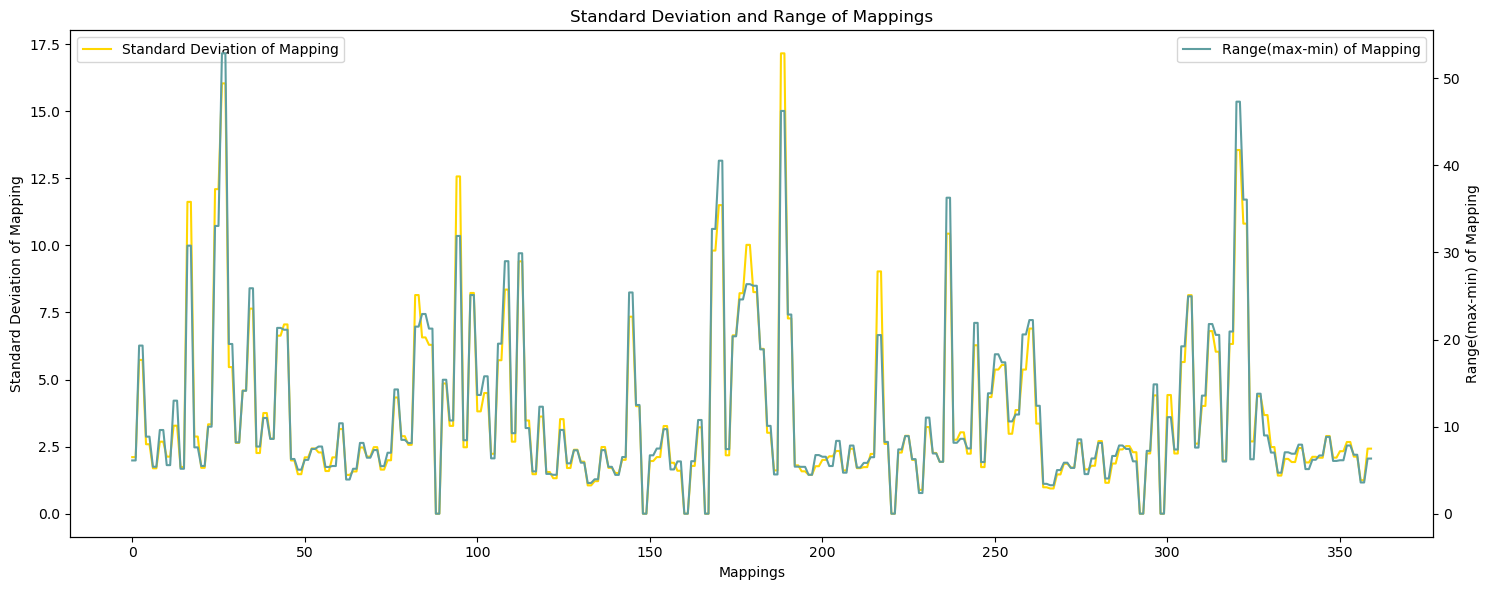

In [84]:
"""
Plot Mapping Data
"""
mapping_data_df = pd.DataFrame(mapping_data)

plotDualAxis(mapping_data_df.index.to_numpy(), 'Mappings', 'Standard Deviation and Range of Mappings', 
             mapping_data_df['avg_packet_lat_std'].to_numpy(), 'Standard Deviation of Mapping', 
             mapping_data_df['avg_packet_lat_range'].to_numpy(), 'Range(max-min) of Mapping', )